In [26]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATASET_MAPPING = 'petfinder-pawpularity-score:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F25383%2F2684322%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20211012%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20211012T175202Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7fd2f02d52ef6a775d61f73941d1b0f46786f2e7b747dfb1a149c993d445d638ac00f56fb8451b1bf6023877a436c1c1dbcd9ae20b58d598c699688e3a362e6c666eafcd315c76cbe5fb2f7ff500bf36a1e36c4460a26462a607df469a60f0fa81ce359a022f11e0f648e015b1c28189ac45adf53c723ebae975a4bcad28056621e6c1c2b643cc97dfcd96d3fe8b090cc0e3985305404bd828c9e5578ca871e556409063fcf54f16ad4f96b73c4aa5e4b5249a4d2af18ebe1ade64bff627c22c600d59f065ee524d8c8cb65f2cbd52cbc05a8aea1333b4992e6aea74ae0dd3bd03d1702f732cf6f81dfc9c9b1a837dca3743a3ef7f83a059b7d00ee2ce874a2d'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

#os.makedirs(KAGGLE_INPUT_PATH, 777)
#os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
os.makedirs(KAGGLE_INPUT_SYMLINK)
os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


[==================================================] 1030728211 bytes downloaded
Unzipping petfinder-pawpularity-score
Dataset import complete.


In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
#Create directory to separate train and validation images
original_dataset_dir = '/kaggle/input/petfinder-pawpularity-score/'
base_dir = '/kaggle/petfinder-pawpularity-score-small/'
os.mkdir(base_dir)


In [29]:
#Creating train,test and validation directory
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [30]:
#Reading score file
csv_path = os.path.join(original_dataset_dir , 'train.csv')
df_score = pd.read_csv(csv_path)

In [31]:
#Reading first ten columns
df_score.head(10)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74
6,0023b8a3abc93c712edd6120867deb53,0,1,1,1,0,0,0,0,1,1,0,0,22
7,0031d6a9ef7340f898c3e05f92c7bb04,0,1,1,0,0,0,1,1,0,0,1,0,35
8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53
9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21


In [32]:
for dirname, _, filenames in os.walk('/kaggle/input/petfinder-pawpularity-score/'):
    print(dirname)

/kaggle/input/petfinder-pawpularity-score/
/kaggle/input/petfinder-pawpularity-score/train
/kaggle/input/petfinder-pawpularity-score/test


In [33]:
def get_score_by_id(filename):
    image_id = filename.split('.')[0]
    if image_id is not None:
        score = df_score[df_score['Id'] == image_id]['Pawpularity'].values[0]
        return score

In [34]:
#Creating cat dataset
train_label = np.array([])
validation_label = np.array([])
for dirname, _, filenames in os.walk('/kaggle/input/petfinder-pawpularity-score/train'):
    for i, fname in enumerate(filenames):
        if i<1000:
            src = os.path.join(dirname, fname)
            dst = os.path.join(train_dir, fname)
            shutil.copyfile(src, dst)
            train_label = np.append(train_label, get_score_by_id(fname))
        elif i>1000 and i<1100:
            src = os.path.join(dirname, fname)
            dst = os.path.join(validation_dir, fname)
            shutil.copyfile(src, dst)
            validation_label = np.append(validation_label, get_score_by_id(fname))
        else:
            pass

In [35]:
print("No of train images in train_dir ", len(os.listdir(train_dir)))
print("No of train images in validation_dir ", len(os.listdir(validation_dir)))

No of train images in train_dir  1000
No of train images in validation_dir  99


In [36]:
print("No of train labels in train_label ",train_label.shape[0])
print("No of train labels in validation_label ",validation_label.shape[0])


No of train labels in train_label  1000
No of train labels in validation_label  99


In [37]:
#test the function
score = get_score_by_id('0007de18844b0dbbb5e1f607da0606e0.jpg')
print(score)

63


In [38]:
#Instatntied VGG16 model 

from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

58900480/58889256 [==============================] - 0s 0us/step


In [39]:
# #Creating a convet model for an integer output
# model = keras.Sequential(([
#     layers.experimental.preprocessing.Resizing(150, 150),
#     layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(), 
#     layers.Dense(512, activation = 'relu'), 
#     layers.Dense(1, activation = 'linear')
# ]))

In [72]:
import glob
import cv2
train_data_np = []
files = glob.glob (train_dir+'/*')
for myFile in files:
    image = cv2.imread (myFile)
    resized = cv2.resize(image, (150, 150), interpolation = cv2.INTER_AREA)
    train_data_np.append(resized/255)
train_data_np = np.array(train_data_np)
print('train_data_np shape:', train_data_np.shape)

train_data_np shape: (1000, 150, 150, 3)


In [64]:
validation_data_np = []
files = glob.glob (validation_dir+'/*')
for myFile in files:
    image = cv2.imread (myFile)
    resized = cv2.resize(image, (150, 150), interpolation = cv2.INTER_AREA)
    validation_data_np.append(resized/255)

validation_data_np = np.array(validation_data_np)
print('validation_data_np shape:', validation_data_np.shape)

validation_data_np shape: (99, 150, 150, 3)


In [75]:
result_val = conv_base.predict(validation_data_np)

In [73]:
result_train = conv_base.predict(train_data_np)

In [77]:
result_val.shape

(99, 4, 4, 512)

In [ ]:
import matplotlib.pyplot as plt
#plt.imshow(result.reshape((4,4), 150))
result[0]

In [79]:
train_features = np.reshape(result_train, (1000, 4 * 4 * 512))
validation_features = np.reshape(result_val, (99, 4 * 4 * 512))

In [80]:
model = keras.Sequential(([
    layers.Dense(256, activation='relu', input_dim=4 * 4 * 512), 
    layers.Dropout(0.5),
    layers.Dense(1, activation='linear')]))
    

In [81]:
model.compile(optimizer='rmsprop',
    loss='mean_squared_error',
    metrics=['mse'])

In [83]:
history = model.fit(train_features, train_label, epochs=50, batch_size=50, validation_data=(validation_features, validation_label))

Epoch 1/50
20/20 [==============================] - 1s 18ms/step - loss: 457.2036 - mse: 457.2036 - val_loss: 264.9324 - val_mse: 264.9324
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 421.8845 - mse: 421.8845 - val_loss: 270.4639 - val_mse: 270.4639
Epoch 3/50
20/20 [==============================] - 0s 18ms/step - loss: 389.6973 - mse: 389.6973 - val_loss: 279.9494 - val_mse: 279.9494
Epoch 4/50
20/20 [==============================] - 0s 17ms/step - loss: 373.6454 - mse: 373.6454 - val_loss: 300.1469 - val_mse: 300.1469
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 339.1667 - mse: 339.1667 - val_loss: 325.1229 - val_mse: 325.1229
Epoch 6/50
20/20 [==============================] - 0s 17ms/step - loss: 332.1790 - mse: 332.1790 - val_loss: 316.5133 - val_mse: 316.5133
Epoch 7/50
20/20 [==============================] - 0s 17ms/step - loss: 295.2277 - mse: 295.2277 - val_loss: 319.0078 - val_mse: 319.0078
Epoch 8/50
20/20 [=========

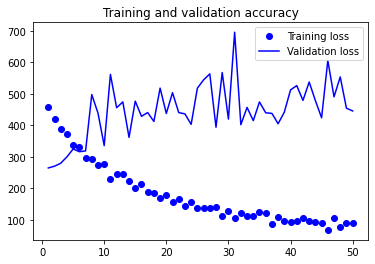

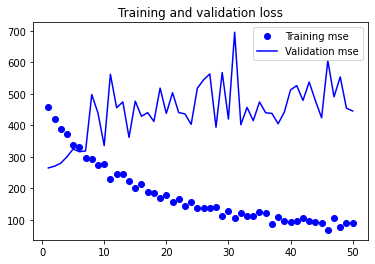

In [89]:
import matplotlib.pyplot as plt
loss = history.history['loss']
mse = history.history['mse']
val_loss = history.history['val_loss']
val_mse = history.history['val_mse']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, mse, 'bo', label='Training mse')
plt.plot(epochs, val_mse, 'b', label='Validation mse')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [85]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])